# Full VE problem analysis template

In [2]:
import os
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import sympy as sym
import torch

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen
import deepymod_torch.VE_params as VE_params
from deepymod_torch.DeepMod import run_deepmod

np_seed = 2
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Data generation

> The below cell is very important for preparing the generation, examination, and saving of the data. It is one of only a few cells that requires configuration in the notebook.

Specify the model parameters

In [3]:
input_type = 'Strain'

# For Boltzmann DG, specific model required for calculation of response given manipulation type. Strain -> GMM, Stress -> GKM.
# For odeint method, no need to consider.
mech_model = 'GMM' 
    
E = 3*[1]
eta = [0.5, 2.5]

In [4]:
# Convert to the equivalent description of model specified by 'model' which is what flow is forced to presume given input_type
# The third arg should be the original format of the model described above, the opposite to what will be assumed by input_type
# E_GMM, eta_GMM = VE_params.convert_between_models(E_GKM, eta_GKM, 'GKM')
# print(E, eta)

In [5]:
E_alt = np.array(E[1:])
eta_alt = np.array(eta)
tau = eta_alt/E_alt
tau

array([0.5, 2.5])

Specify the functional form of the input

In [6]:
func_desc = 'Half Sinc'

#t = sym.symbols('t', real=True)
#input_expr = sym.sinc(omega*t)

# Wave packets
# omega = 2.5
# amp = 7
# input_expr, d_input_expr, input_torch_lambda = VE_datagen.wave_packet_lambdas_sum(omega, 0.5, 3, amp)

# step
# input_expr = lambda t: 1
# d_input_expr = lambda t: 0
# input_torch_lambda = lambda t: 1 + 0*t

# width_val = 0.1
# input_expr = sigmoid_expr(width=width_val)
# d_input_expr = d_sigmoid_expr(width=width_val)
# input_torch_lambda = sigmoid_torch_expr(width=width_val)

# sine
# omega = 1
# input_expr = lambda t: np.sin(omega*t)
# d_input_expr = lambda t: omega*np.cos(omega*t)
# input_torch_lambda = lambda t: torch.sin(omega*t)

# sinc
omega = 1
Amp = 7
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
input_torch_lambda = lambda t: Amp*torch.sin(omega*t)/(omega*t)

# sinc with hshift
# omega = 1
# shift = 6*np.pi
# input_expr = lambda t: np.sin(omega*(t - shift))/(omega*(t - shift))
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - shift))/(omega*(t - shift))

# sinc with vshift
# omega = np.pi
# neg_edge = -7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_no_shift = lambda t: np.sin(omega*t)/(omega*t)
# vshift = input_expr_no_shift(neg_edge)
# input_expr = lambda t: input_expr_no_shift(t) - vshift
# d_input_expr = lambda t: (1/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
# input_torch_lambda = lambda t: torch.sin(omega*t)/(omega*t) - vshift

# sinc with both hshift and vshift
# omega = np.pi
# hshift = 7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_h_only = lambda t: np.sin(omega*(t - hshift))/(omega*(t - hshift))
# vshift = input_expr_h_only(0)
# input_expr = lambda t: input_expr_h_only(t) - vshift
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - hshift))/(omega*(t - hshift)) - vshift

# # soft step
# def sigmoid_expr(max_value=1, h_shift=0, width=1):
#     return lambda t: max_value / (1 + np.exp(-(t-h_shift)/width))

# def d_sigmoid_expr(max_value=1, h_shift=1, width=1): # h_shift is wrong
#     sig = sigmoid_expr(h_shift=h_shift, width=width)
#     return lambda t: (max_value/width) * sig(t) * (1 - sig(t))

# def sigmoid_torch_expr(max_value=1, h_shift=0, width=1):
#     return lambda t: max_value / (1 + torch.exp(-(t-h_shift)/width))

# width_val = 0.1
# shift_val = 5*(-2*np.pi/omega)
# input_expr_2 = sigmoid_expr(h_shift=shift_val, width=width_val)
# # d_input_expr_2 = d_sigmoid_expr(h_shift=shift_val, width=width_val)
# input_torch_lambda_2 = sigmoid_torch_expr(h_shift=shift_val, width=width_val)

In [7]:
# # Multiplying 2 signals together (product rule)
# input_expr = lambda t: input_expr_1(t) * input_expr_2(t)
# d_input_expr = lambda t: input_expr_1(t) * d_input_expr_2(t) + d_input_expr_1(t) * input_expr_2(t)
# input_torch_lambda = lambda t: input_torch_lambda_1(t) * input_torch_lambda_2(t)

Specify the independant data points over which to synthesise the data.

In [8]:
time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)

In [9]:
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

In [10]:
# strain_array, stress_array = VE_datagen.calculate_int_diff_equation_initial(time_array, input_expr, E, eta, input_type, mech_model)

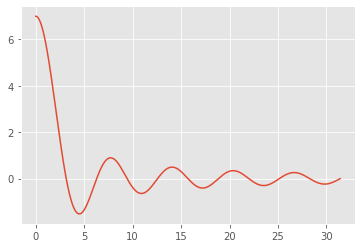

In [11]:
plt.plot(time_array.flatten(), strain_array.flatten(), label='strain')

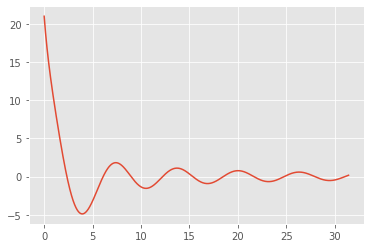

In [12]:
plt.plot(time_array.flatten(), stress_array.flatten(), label='stress')

## Generation Validation

In [13]:
unscaled_coeffs = VE_params.coeffs_from_model_params(E, eta, mech_model)
unscaled_coeffs

[0.166666666666667,
 0.625000000000000,
 0.166666666666667,
 0.500000000000000,
 0.208333333333333]

In [14]:
errors = VE_datagen.equation_residuals(time_array, strain_array, stress_array, unscaled_coeffs)

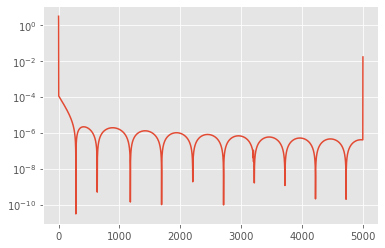

In [15]:
plt.semilogy(abs(errors.flatten()))

## Data Treatment

### Scaling

Presence of t/time_sf in new lambdas is hard to understand but has a reason. The reason is that while unscaled t, stress and strain all map to each other, they need to all map once scaled also. Scaling the time array does not change the target array as these are both precalculated. however, because the analytical input data is calculated based off this NEW SCALED time series in the library function, it is calculated over the scaled time series for the old function, effectively doubling the number of bumps in the curve, rather than stretching it out. we want to calculate the old input_data, ie that originates from the unscaled time data, so we have to unscale the time data on the fly in the library, hence the factor in the lambda function.

This allows PyTorch to map scaled time to scaled input and calculate the appropriate derivatives

Note, this is not an issue for the real data as there is no analytical input term, and the input variable is a dumb target, just like the output variable.

In [16]:
# 'normalising'
time_sf = omega/1.2
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))
print(time_sf, strain_sf, stress_sf)

scaled_time_array = time_array*time_sf
scaled_strain_array = strain_array*strain_sf
scaled_stress_array = stress_array*stress_sf
if input_type == 'Strain':
    scaled_input_expr = lambda t: strain_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: strain_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = scaled_stress_array
elif input_type == 'Stress':
    scaled_input_expr = lambda t: stress_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: stress_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = scaled_strain_array

0.8333333333333334 0.14285714285714285 0.047619047619047616


#### Predicting Coefficients

Scale the true coeffs to what deepmod should find based on the scaling of each term in the equation.

In [17]:
expected_coeffs = VE_params.scaled_coeffs_from_true(unscaled_coeffs, time_sf, strain_sf, stress_sf)

#### Scaling Validation

In [18]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, scaled_stress_array, expected_coeffs)

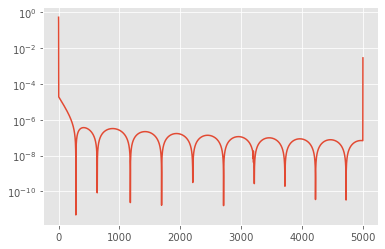

In [19]:
plt.semilogy(abs(errors.flatten()))

### Noise

In [20]:
# add noise
noise_level = 0

noisy_target_array = scaled_target_array + noise_level * np.std(scaled_target_array) * np.random.standard_normal(scaled_target_array.shape)

### Random Sampling

In [21]:
# sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(scaled_time_array.size)

reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = noisy_target_array[reordered_row_indices, :][:number_of_samples]

# The below code is a slight alternative version that produces data and targets that are still in chronological order.
# selected_row_indices = reordered_row_indices[:number_of_samples]
# selected_row_indices.sort()
# reduced_time_array = scaled_time_array[selected_row_indices, :]
# reduced_target_array = noisy_target_array[selected_row_indices, :]

## Defining Library

In [22]:
import torch.autograd as auto
    
def mech_library(inputs, **library_config):    
    
    prediction, data = inputs
    
    # Load already calculated derivatives of manipulation variable
    input_theta = library_config['input_theta']
    if data.shape[0] == 1: # Swaps real input_theta out for dummy in initialisation pass.
        input_theta = torch.ones((1, input_theta.shape[1]))
    
    # Automatic derivatives of response variable 
    output_derivs = auto_deriv(data, prediction, library_config['diff_order'])
    output_theta = torch.cat((prediction, output_derivs), dim=1)
    
    # Identify the manipulation/response as Stress/Strain and organise into returned variables
    if library_config['input_type'] == 'Strain':
        strain = input_theta
        stress = output_theta
    else: # 'Stress'
        strain = output_theta
        stress = input_theta
        
    strain_t = strain[:, 1:2] # Extract the first time derivative of strain
    strain = torch.cat((strain[:, 0:1], strain[:, 2:]), dim=1) # remove this before it gets put into theta
    strain *= -1 # The coefficient of all strain terms will always be negative. rather than hoping deepmod will find these negative terms, we assume the negative factor here and later on DeepMoD will just find positive coefficients
    theta = torch.cat((strain, stress), dim=1) # I have arbitrarily set the convention of making Strain the first columns of data
    
    return [strain_t], theta


def auto_deriv(data, prediction, max_order):
    '''
    data and prediction must be single columned tensors.
    If it is desired to calculate the derivatives of different predictions wrt different data, this function must be called multiple times.
    This function does not return a column with the zeroth derivative (the prediction).
    '''
    
    # First derivative builds off prediction.
    derivs = auto.grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    for _ in range(max_order-1):
        # Higher derivatives chain derivatives from first derivative.
        derivs = torch.cat((derivs, auto.grad(derivs[:, -1:], data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]), dim=1)
            
    return derivs

## DeepMod prep

In [23]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

#### Manipulation derivative library pre-calculation

In [24]:
library_diff_order = 3

input_data = scaled_input_torch_lambda(time_tensor)
input_derivs = auto_deriv(time_tensor, input_data, library_diff_order)
input_theta = torch.cat((input_data.detach(), input_derivs.detach()), dim=1)

#### Threshold definition

In [25]:
percent = 0.05
thresh_pc = lambda *args: percent

#### Config dictionaries

In [26]:
library_config = {'library_func': mech_library,
                  'diff_order': library_diff_order,
                  'coeff_sign': 'positive',
                  'input_type': input_type,
                  'input_theta': input_theta}

In [27]:
network_config = {'hidden_dim': 30}

In [28]:
optim_config = {'lr_coeffs': 0.002,
                'thresh_func': thresh_pc,
                'l1': 10**-6}

In [29]:
report_config = {'plot': True}

## Running DeepMoD

In [30]:
expected_coeffs

[0.200000000000000,
 0.520833333333333,
 0.600000000000000,
 1.50000000000000,
 0.520833333333333]

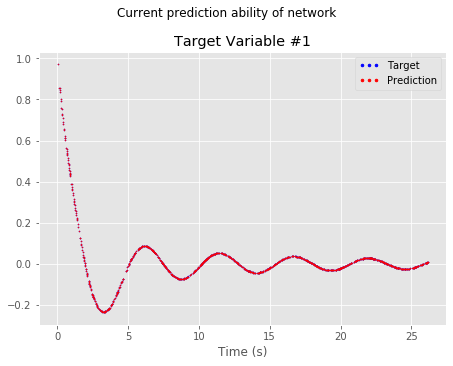

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |     Sign |
      10000     99.99%               0s   7.64e-08   5.63e-09   7.08e-08   0.00e+00   0.00e+00 
[Parameter containing:
tensor([[0.1995],
        [0.5273],
        [0.5949],
        [1.5021],
        [0.5261]], requires_grad=True)]


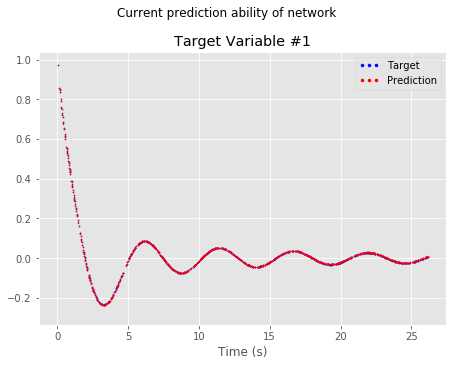

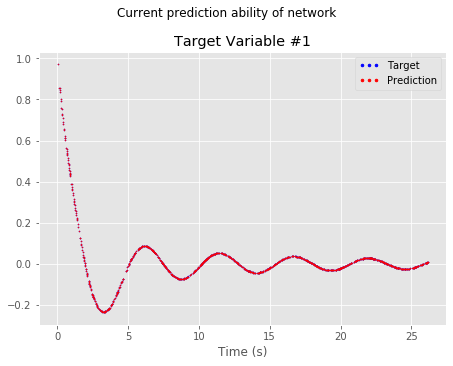

In [31]:
begin_timestamp = datetime.now()
model = run_deepmod(time_tensor, target_tensor, library_config, network_config, optim_config, report_config)

In [32]:
network = model.network
lstsq_guess_list = model.fit.initial_guess
sparse_coeff_vector_list_list = model.fit.coeff_vector_history
# scaled_coeff_vector_list_list = [] # NOT IMPLEMENTED
sparsity_mask_list_list = model.fit.sparsity_mask_history

### Results

In [33]:
lstsq_guess_list

In [34]:
[list(plist) for plist in sparse_coeff_vector_list_list]

[[Parameter containing:
  tensor([[2.2136e-01],
          [5.1992e-01],
          [2.4216e-02],
          [5.9863e-01],
          [1.4423e+00],
          [5.0255e-01],
          [3.2173e-04]], requires_grad=True)], [Parameter containing:
  tensor([[0.1995],
          [0.5273],
          [0.5950],
          [1.5021],
          [0.5261]], requires_grad=True)]]

In [35]:
# scaled_coeff_vector_list_list

In [36]:
sparsity_mask_list_list

[[tensor([0, 1, 2, 3, 4, 5, 6])], [tensor([0, 1, 3, 4, 5])]]

## Investigating prediction and discovered model

In [37]:
time_tensor_post = torch.tensor(scaled_time_array, dtype=torch.float32, requires_grad=True)
prediction_tensor = network(time_tensor_post)
full_prediction_array = np.array(prediction_tensor.detach())

### Expected coeffs match with prediction?

In [38]:
if input_type == 'Strain':
    errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, full_prediction_array, expected_coeffs)
else:
    errors = VE_datagen.equation_residuals(scaled_time_array, full_prediction_array, scaled_stress_array, expected_coeffs)

0.00046210782485171673


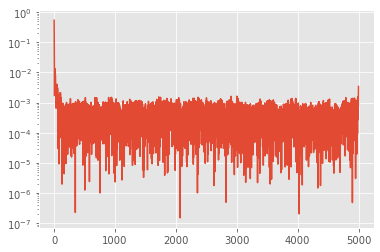

In [39]:
print(np.mean(abs(errors[library_diff_order:-library_diff_order])))
plt.semilogy(abs(errors.flatten()))

### DeepMoD coeffs match with prediction?

In [40]:
coeff_vector = sparse_coeff_vector_list_list[0][0].clone().detach()

In [41]:
if input_type == 'Strain':
    errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, full_prediction_array, coeff_vector)
else:
    errors = VE_datagen.equation_residuals(scaled_time_array, full_prediction_array, scaled_stress_array, coeff_vector)

0.0005384461762420509


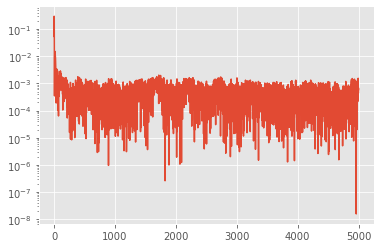

In [42]:
print(np.mean(abs(errors[library_diff_order:-library_diff_order])))
plt.semilogy(abs(errors.flatten()))

### DeepMoD coeffs match with full target?

In [43]:
coeff_vector = sparse_coeff_vector_list_list[0][0].clone().detach()

In [44]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, scaled_stress_array, coeff_vector)

0.0002829166578292952


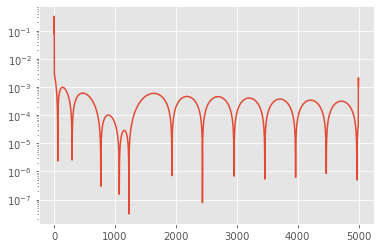

In [45]:
print(np.mean(abs(errors[library_diff_order:-library_diff_order])))
plt.semilogy(abs(errors.flatten()))

### Model before thresholding

#### Plotting data from coeffs

In [46]:
coeff_vector = sparse_coeff_vector_list_list[0][0].clone()
sparsity_mask = sparsity_mask_list_list[0][0].clone()

In [47]:
response_recalc_bt = VE_datagen.calculate_int_diff_equation(time_tensor_post, prediction_tensor, scaled_input_expr, coeff_vector, sparsity_mask, library_diff_order, input_type)

In [71]:
# Alt finite difference method
coeff_vector_array = np.array(coeff_vector.detach())
response_recalc_bt_fd = VE_datagen.calculate_finite_difference_diff_equation(scaled_time_array, scaled_strain_array, full_prediction_array, coeff_vector_array, sparsity_mask, library_diff_order, input_type)

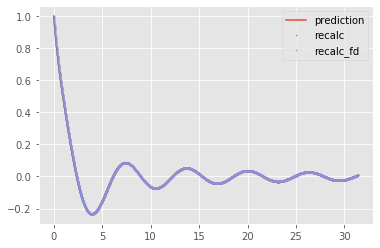

In [72]:
plt.plot(time_array.flatten(), full_prediction_array.flatten(), label='prediction')
plt.plot(time_array.flatten(), response_recalc_bt.flatten(), label='recalc', marker='.', markersize=1, linestyle='None')
plt.plot(time_array.flatten(), response_recalc_bt_fd.flatten(), label='recalc_fd', marker='.', markersize=1, linestyle='None')
plt.legend()

#### Validation

In [73]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, full_prediction_array, coeff_vector_array, sparsity_mask=sparsity_mask, diff_order=library_diff_order)

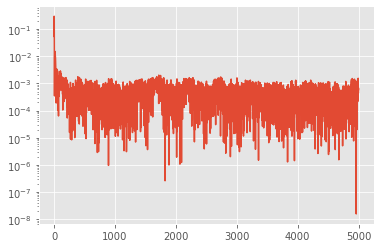

In [74]:
plt.semilogy(abs(errors.flatten()))

### Model after thresholding

#### Plotting data from coeffs

In [75]:
coeff_vector = sparse_coeff_vector_list_list[-1][0].clone()
sparsity_mask = sparsity_mask_list_list[-1][0].clone()

In [76]:
response_recalc_at = VE_datagen.calculate_int_diff_equation(time_tensor_post, prediction_tensor, scaled_input_expr, coeff_vector, sparsity_mask, library_diff_order, input_type)

In [77]:
# Alt finite difference method
coeff_vector_array = np.array(coeff_vector.detach())
response_recalc_at_fd = VE_datagen.calculate_finite_difference_diff_equation(scaled_time_array, scaled_strain_array, full_prediction_array, coeff_vector_array, sparsity_mask, library_diff_order, input_type)

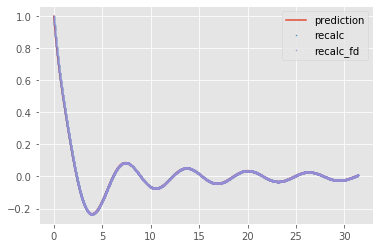

In [78]:
plt.plot(time_array.flatten(), full_prediction_array.flatten(), label='prediction')
plt.plot(time_array.flatten(), response_recalc_at.flatten(), label='recalc', marker='.', markersize=1, linestyle='None')
plt.plot(time_array.flatten(), response_recalc_at_fd.flatten(), label='recalc_fd', marker='.', markersize=1, linestyle='None')
plt.legend()

#### Validation

In [79]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, full_prediction_array, coeff_vector_array, sparsity_mask=sparsity_mask, diff_order=library_diff_order)

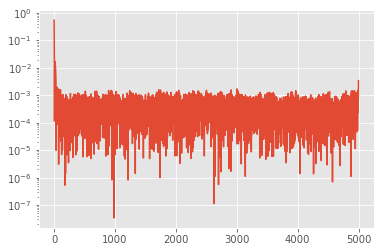

In [80]:
plt.semilogy(abs(errors.flatten()))

## Results Processing

In [81]:
investigated_param = f'Working reference Strain GMM 2nd order'

In [82]:
prediction_array = np.array(network(time_tensor).detach())
full_prediction_array = full_prediction_array.reshape(-1, 1)

if `prediction_coeffs_array` is not equal dimensionally to the `target_coeffs_array`, there would be an error if it weren't for the `if` statement prempting this. In the case where the dimensions don't agree, there is no sensible way to assess these quantities anyway, so this data is mostly abandoned. The coeffs before thresholding are however saved as `pre_thresh_coeffs_array`.

In [84]:
target_coeffs_array = np.array(expected_coeffs).reshape(-1,1)

pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach())
# pre_thresh_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[0][0].detach())

final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach())
# final_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[-1][0].detach())
sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0]).reshape(-1,1)

if statement just bypasses errors

In [85]:
dg_series_data = np.concatenate((time_array, strain_array, stress_array), axis=1)
NN_series_data = np.concatenate((reduced_time_array, reduced_target_array, prediction_array), axis=1)
# pre_thresh_coeffs_data = np.concatenate((pre_thresh_coeffs_array, pre_thresh_scaled_coeffs_array), axis=1)
# final_coeffs_data = np.concatenate((final_coeffs_array, final_scaled_coeffs_array, sparsity_mask_array), axis=1)

pre_thresh_coeffs_data = pre_thresh_coeffs_array
final_coeffs_data = np.concatenate((final_coeffs_array, sparsity_mask_array), axis=1)

In [86]:
dt_string = begin_timestamp.strftime('%d/%m/%Y %H:%M:%S')

In [87]:
library_config.pop('strain_array', None)
library_config.pop('input_theta', None)

tensor([[ 0.0055, -0.0548, -0.0020,  0.0788],
        [ 0.0368,  0.0085, -0.0538, -0.0074],
        [-0.0160,  0.1962, -0.0531, -0.2472],
        ...,
        [ 0.2155, -0.4926,  0.1518,  0.3500],
        [ 0.0300,  0.0274, -0.0458, -0.0351],
        [-0.2171,  0.0097,  0.3074, -0.1755]])

In [88]:
dg_info_list = [f'Model: '+mech_model, f'E: {E}', f'eta: {eta}', 'Input: '+input_type, 'Desc: '+func_desc, f'omega: {omega}', f'Amp: {Amp}']
dg_info_list

['Model: GMM',
 'E: [1, 1, 1]',
 'eta: [0.5, 2.5]',
 'Input: Strain',
 'Desc: Half Sinc',
 'omega: 1',
 'Amp: 7']

In [89]:
treatment_info_list = [f'noise_factor: {noise_level}', f'time_sf: {time_sf}', f'strain_sf: {strain_sf}', f'stress_sf: {stress_sf}']
treatment_info_list

['noise_factor: 0',
 'time_sf: 0.8333333333333334',
 'strain_sf: 0.14285714285714285',
 'stress_sf: 0.047619047619047616']

In [90]:
config_dict_list = [f'library: {library_config}', f'network: {network_config}', f'optim: {optim_config}', f'report: {report_config}']
config_dict_list

["library: {'library_func': <function mech_library at 0x7f5265cb5e18>, 'diff_order': 3, 'coeff_sign': 1, 'input_type': 'Strain'}",
 "network: {'hidden_dim': 30, 'pre_trained_network': None, 'layers': 4}",
 "optim: {'lr_coeffs': 0.002, 'thresh_func': <function <lambda> at 0x7f5265cb5ae8>, 'l1': 1e-06, 'PINN': False, 'kappa': 1, 'lr_nn': 0.001, 'betas': (0.9, 0.999), 'amsgrad': False, 'mse_only_iterations': None, 'max_iterations': 100001, 'final_run_iterations': 10001, 'use_lstsq_approx': False}",
 "report: {'plot': True, 'print_interval': 1000}"]

In [91]:
misc_list = ['date_stamp: '+dt_string, f'NumPy_seed: {np_seed}', f'Torch_seed: {torch_seed}']
misc_list

['date_stamp: 04/06/2020 10:40:15', 'NumPy_seed: 2', 'Torch_seed: 0']

In [92]:
# GKM_list = [f'E_GKM: {E_GKM}', f'eta_GKM: {eta_GKM}']
# GKM_list

## Saving

In [93]:
parent_folder = '../data/Results'
first_subfolder = investigated_param.replace('.', '-')

foldername = parent_folder + '/paper_plots/' + first_subfolder

In [94]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

In [95]:
np.savetxt(foldername+'/DG_series_data.csv', dg_series_data, delimiter=',', header='Time, Strain, Stress')
np.savetxt(foldername+'/NN_series_data.csv', NN_series_data, delimiter=',', header='Time, Target, Prediction')
np.savetxt(foldername+'/expected_coeffs.csv', target_coeffs_array, delimiter=',', header='Expected_coeffs')
# np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs')
# np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs, Sparsity_Mask')

np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs')
np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Sparsity_Mask')
np.savetxt(foldername+'/full_prediction.csv', full_prediction_array, delimiter=',', header='Full Prediction')

In [96]:
with open(foldername+'/DG_info_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in dg_info_list)

In [97]:
with open(foldername+'/treatment_info_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in treatment_info_list)

In [98]:
with open(foldername+'/config_dict_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in config_dict_list)

In [99]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in misc_list)

In [100]:
# with open(foldername+'/GKM_list.txt', 'w') as file:
#     file.writelines(f'{line}\n' for line in GKM_list)

## Rediscovering mechanical model parameters if possible

We need to take the coefficients that DeepMoD has found and reverse the process in predicting coeffients.

First we do the reverse scaling of the coeffs, this time dividing by the multiplication factor previously found, to scale the scaled coefficients to the true ones.

In [101]:
result = sparse_coeff_vector_list_list[-1][0].clone().detach()
true_coeffs = VE_params.true_coeffs_from_scaled(result, time_sf, strain_sf, stress_sf)
true_coeffs

[0.16621137658754986,
 0.6327210903167725,
 0.1652697390980191,
 0.5006974538167318,
 0.2104229211807251]

We next use these coefficients to recover our model parameters.

In [102]:
recovered_mech_params = VE_params.model_params_from_coeffs(true_coeffs, mech_model)[0][0]
recovered_mech_params

(1.00569757957307,
 1.01422030248816,
 0.986984059830119,
 0.511326605100348,
 2.49254927264687)

#### Save results if poss

In [103]:
recovered_mech_params_array = np.array(recovered_mech_params).reshape(-1,1)
np.savetxt(foldername+'/recovered_mech_params.csv', recovered_mech_params, delimiter=',', header='Recovered')